# Reproducible Code
For maximal reproducibility, we recommend running the 'Create_VirtualEnv....ipynb' using the default shell of your OS or bash. You then need to change the current notebook's kernel to 'RadTMSR_env,' which stores all required versions of the used modules.

**Written in Python 4.20.11, Jupyter Lab 4.0.7, and R 4.3.0**

In [1]:
input("Ensure that kernel is set to RadTMSR_env before continuing")

Ensure that kernel is set to RadTMSR_env before continuing y


'y'

In [2]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import subprocess
import spacy
nlp = spacy.load('en_core_web_sm')
import networkx as nx
from scipy.stats import binom_test

In [3]:
## create folder for storing output
if not os.path.exists("RTMR_Output"):
    os.makedirs("RTMR_Output")
if not os.path.exists("RTMR_Output/Abstracts"):
    os.makedirs("RTMR_Output/Abstracts")

#### **To run this script successfully, R must be installed and Rscript.exe must be in the local environment's PATH.**

To ensure that Rscript.exe is in the PATH, follow these steps:

1. Run the cell below. If Rscript.exe is found, you are informed that R scripts can be run successfully. If Rscript.exe is not found, you will need to provide the absolute path to the Rscript.exe file. To do this, follow these instructions:

2. Locate the Rscript.exe file, which is usually in the bin folder of your R installation directory. The path might look something like C:\Program Files\R\R-x.x.x\bin.

In [4]:
try:
    result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
    print("Rscript version:", result.stdout)
    print("R scripts can be successfully run.")
    
except FileNotFoundError:
    rscript_path = input("Rscript.exe not found. Please enter the absolute directory path where Rscript.exe is located: ")
    print("Absolute path provided: ", rscript_path)
    
    # Add the path to the PATH environment variable for the current session
    os.environ['PATH'] += os.pathsep + rscript_path
    
    # Verify if Rscript is accessible this time
    try:
        result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
        print("Rscript version:", result.stdout)
        print("R scripts can be successfully run.")
    except FileNotFoundError:
        raise Exception("Rscript not found. Please check the path.")

Rscript version: Rscript (R) version 4.3.2 (2023-10-31)

R scripts can be successfully run.


## Study 2 - Abstract Analysis

In [5]:
# Import data
dfTot = pd.read_excel("asreview_dataset_relevant_Radicalization.xlsx")
#dfTot.head()

In [6]:
data = dfTot[["record_id","Abstract"]].copy()
data.rename(columns={'Abstract': 'abstract'}, inplace=True)

In [7]:
data = data.dropna(subset = ['abstract']).reset_index(drop=True)
data

,record_id,abstract
0,50129,This research examines how the relationship be...
1,2624,Religion is often seen as one of the main caus...
2,35510,Why are some people capable of sympathizing wi...
3,43427,In this study among Dutch Muslim youth (N= 131...
4,986,Despite its prominence in radicalization model...
...,...,...
4014,24073,This article focuses on the place and role of ...
4015,22510,Islamist militancy is not a new phenomenon in ...
4016,50382,Results of an empirical study of long-term goa...
4017,2188,The purpose of this study is to examine the ef...


# Preprocessing

**Pipeline**:

`data` --> `pre-processing`

* strip punctuation, exclude non-letters, but keep "-" between words
* part-of-speech tagging - retain adjectives and nouns only
* lower case
* lemmatise

--> `exclusion filter (stopwords, countries, exclusion terms)` --> `n-gram extraction`

* 1 - 3-grams

--> `classification and replacement`

* Replace according to dictionary order (vs. overlapping as in keywords) ?




--> `tokenbydoc` --> *transfer to R* --> `negative binomial` --> `topic modelling` --> `frequence analysis` --> `co-occurrence analysis` --> *transfer to Python* --> `co-occurrence network map`

### 1. Cleaning

In [8]:
from Word_functions.word_functions_py import strip_characters, POS_tagging, lemmatisation

**strip punctuation, exclude non-letters**

In [9]:
data.abstract[4014]

"This article focuses on the place and role of women in the ideology of the Greek neo-Nazi political party Golden Dawn (GD). The article considers the place of women in GD's ideology as well as how GD envisages the role of women in society. It asks whether this vision of women's role is reflected in the participation of women in the party's activities. Based on a content analysis of material derived from the party's official websites, it is argued that women play a key role in GD's ideological edifice. This is evident in the party's concern with the construction of a nationalist habitus for women. This habitus is rooted in ideas of anti-feminism, motherhood and family and the primacy of nation and nationalist sentiment in determining women's lives."

In [10]:
data.abstract = data.abstract.apply(strip_characters)

In [11]:
data.abstract[4014]

'This article focuses on the place and role of women in the ideology of the Greek neo Nazi political party Golden Dawn GD The article considers the place of women in GD ideology as well as how GD envisages the role of women in society It asks whether this vision of women role is reflected in the participation of women in the party activities Based on a content analysis of material derived from the party official websites it is argued that women play a key role in GD ideological edifice This is evident in the party concern with the construction of a nationalist habitus for women This habitus is rooted in ideas of anti feminism motherhood and family and the primacy of nation and nationalist sentiment in determining women lives'

**POS tagging**

In [12]:
data.abstract = data.abstract.apply(POS_tagging)

In [13]:
data.abstract[4014]

'article place role women ideology Greek neo political party article place women ideology role women society vision women role participation women party activities content analysis material party official websites women key role ideological edifice evident party concern construction nationalist habitus women habitus ideas anti feminism motherhood family primacy nation nationalist sentiment women lives'

**lower case**

In [14]:
data.abstract = data.abstract.apply(lambda x: " ".join([str(item).lower() for item in x.split(" ")]))

In [15]:
data.abstract[4014]

'article place role women ideology greek neo political party article place women ideology role women society vision women role participation women party activities content analysis material party official websites women key role ideological edifice evident party concern construction nationalist habitus women habitus ideas anti feminism motherhood family primacy nation nationalist sentiment women lives'

**lemmatisation**

In [16]:
data.abstract = data.abstract.apply(lemmatisation)

In [17]:
data.abstract[4014]

'article place role woman ideology greek neo political party article place woman ideology role woman society vision woman role participation woman party activity content analysis material party official website woman key role ideological edifice evident party concern construction nationalist habitus woman habitus ideas anti feminism motherhood family primacy nation nationalist sentiment woman live'

-------------------------------------------------------------------------------------------

### *Frequency of Countries and Regions*
(needs to be executed before term exclusion)

In [18]:
from country_list import countries_for_language
countries_dict = dict(countries_for_language('en'))
countries_raw = list(countries_dict.values())
countries = [term.lower() for term in countries_raw]

region_list = ['africa','asia','europe','america','middle east',
               "western europe", "northern ireland", "hong kong", "basque country",
               "eastern europe", "southeast asia", "south asia", "somali", "britain", "latin america", "central asia",
               "palestine", 'middle east and north africa']

In [19]:
regions_data = data.copy(deep=True)
regions_col = []
for element in data.abstract:
    temp_col = []
    for term in countries+region_list:
        if term in element:
            temp_col.append(term)
    regions_col.append(temp_col)

regions_data["region"] = regions_col

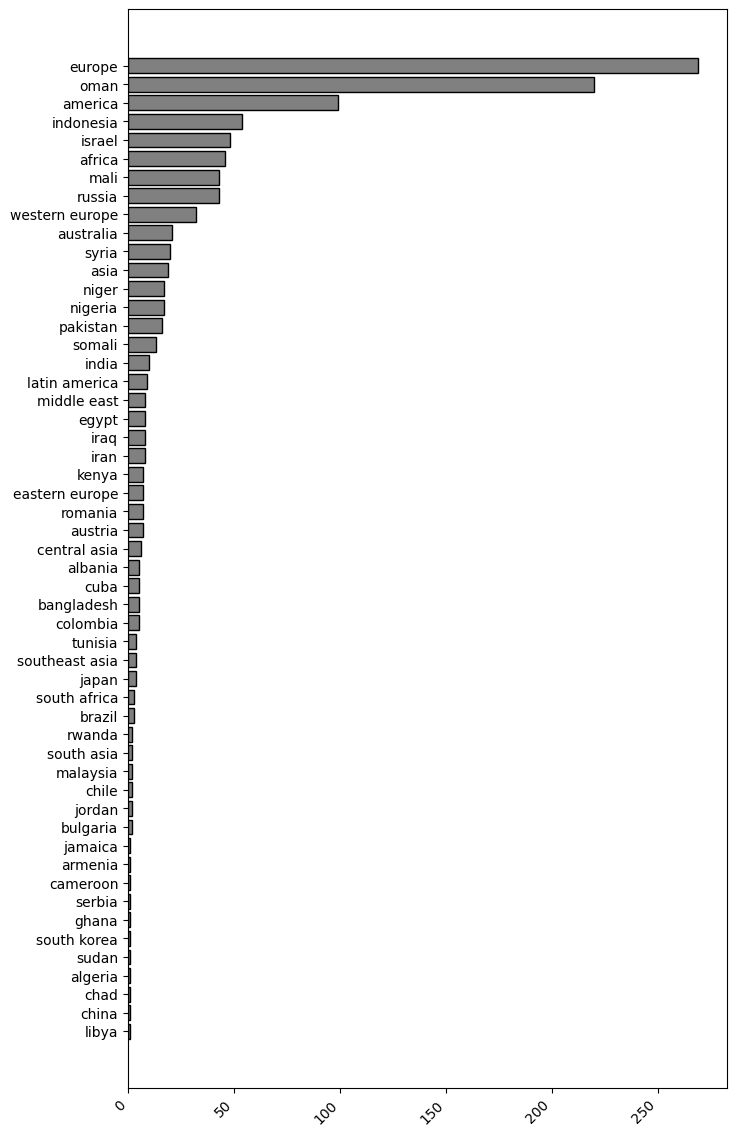

In [20]:
# Calculate frequency of regions
freq_regions = {key: value for key, value in Counter(regions_data.region.apply(lambda x: list(set(x))).sum()).items() if key in countries + region_list}
freq_regions = pd.Series(dict(sorted(freq_regions.items(), key=lambda item: item[1])))

# Save frequencies to Excel file
freq_regions.to_excel('RTMR_Output/Abstracts/Abstracts_Regions_freq.xlsx')

# Plotting
plt.figure(figsize=(8, 12))
plt.barh(freq_regions.index, freq_regions, edgecolor='black', color='gray')

# Customize x-axis labels
plt.xticks(rotation=45, ha="right")  # Rotate labels to 45 degrees

# Adjust layout
plt.tight_layout(pad=3)

plt.savefig('RTMR_Output/Abstracts/Abstracts_Regions_freq_barplot.png', bbox_inches='tight', dpi=600)
plt.show()


---------------------------------------------------------------------------------

### 2. Exclusion Filter

In [21]:
from stop_words import get_stop_words
stoplist = get_stop_words('en')

In [22]:
exclusion_list = pd.read_excel("Exclusion_def.xlsx")
excl_list = list(exclusion_list.Exclusion)
excl_list = [str(item) for item in excl_list]

In [23]:
exclusion_filter = set(excl_list + countries + stoplist + region_list)
exclusion_filter_string = "\\b" + " \\b|\\b".join(exclusion_filter) + " \\b"

In [24]:
data.abstract = data.abstract.apply(lambda x: re.sub(exclusion_filter_string, "", x))
#data

In [25]:
data.to_json('RTMR_Output/Abstracts/Abstracts_data_preprocessed.json', orient='records', lines=True)

### 3. N-gram Extraction

In [26]:
#data = pd.read_json('RTMR_Output/Abstracts/Abstracts_data_preprocessed.json', orient='records', lines=True)

In [27]:
from Word_functions.word_functions_py import ngram_extractor, trigram_to_nounbydoc, bigram_to_nounbydoc, relevant_trigrams, select_unigrams, to_nounbydoc

In [28]:
data.abstract = data.abstract.apply(lambda x: x.split(" "))

In [29]:
# remove consecutive duplicates
data.abstract = data.abstract.apply(lambda x: [element for idx, element in enumerate(x) if idx == 0 or element != x[idx-1]])

In [30]:
data["ngram"] = data.abstract.apply(ngram_extractor)

#### Identifying Meaningful N-grams 

**Workflow**:

1. N-grams can be considered meaningful if they occur above chance.
2. To this end, the occurrence of trigrams will be modelled with a negative binomial distribution

In [31]:
trigram_nounbydoc = trigram_to_nounbydoc(data)
#trigram_nounbydoc

In [32]:
trigram_nounbydoc.to_csv("RTMR_Output/Abstracts/trigram_nounbydoc.csv", index=False)

In [33]:
os.chdir("Word_functions")
r_script_path = 'trigrams_pruning.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


In [34]:
meaningful_trigrams = list(pd.read_csv("RTMR_Output/Abstracts/trigrams_pruned.csv").Word)

In [35]:
data[["trigrams","residual_ngrams"]] = data.ngram.apply(lambda x: pd.Series(relevant_trigrams(x, meaningful_trigrams)))

In [36]:
data.head()

,record_id,abstract,ngram,trigrams,residual_ngrams
0,50129,"[relationship, passion, ideology, violent, act...","[[relationship passion ideology, relationship ...","[obsessive harmonious passion, collective loss...","[relationship passion, passion ideology, ideol..."
1,2624,"[religion, main, extremist, violence, suicide,...","[[religion main extremist, religion main], [ma...",[support extremist violence],"[religion main, main extremist, extremist viol..."
2,35510,"[capable, andor, act, political, violence, att...","[[capable andor act, capable andor], [andor ac...","[act political violence, extreme political vio...","[capable andor, andor act, nan, violence attac..."
3,43427,"[dutch, muslim, youth, radicalization, main, p...","[[dutch muslim youth, dutch muslim], [muslim y...",[],"[dutch muslim, muslim youth, youth radicalizat..."
4,986,"[prominence, understand, extent, identity, ext...","[[prominence understand extent, prominence und...",[],"[prominence understand, understand extent, ext..."


**Next Step: Selecting Meaningful 2-grams**

In [37]:
bigrams_nounbydoc = bigram_to_nounbydoc(data)
#bigrams_nounbydoc

In [38]:
bigrams_nounbydoc.to_csv("RTMR_Output/Abstracts/bigrams_nounbydoc.csv",index=False)

In [39]:
os.chdir("Word_functions")
r_script_path = 'bigrams_pruning.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


In [40]:
meaningful_bigrams = list(pd.read_csv("RTMR_Output/Abstracts/bigrams_pruned.csv").Word)

In [41]:
data["bigrams"] = data.residual_ngrams.apply(lambda x: list(set([element for element in x if element in meaningful_bigrams])))

**Combining Meaningful Trigrams, Bigrams, and Unigrams**

In [42]:
select_unigrams(data)

In [43]:
#data.drop("residual_ngrams",axis=1,inplace=True)
data['keywords'] = data.apply(lambda row: list(set(row['trigrams'] + row['bigrams'] + row['resid_onegrams'])), axis=1)
#data['keywords'] = data.apply(lambda row: list(set(row['trigrams'] + row['bigrams'])), axis=1)
#data.head()

### 4. Classification and Replacement

Related terms are clustered into groups and assigned an overarching umbrella term (e.g. "adoloscence" <- "youth" & "adoloscents"). We call this process classification. Subsequently, related terms are replaced by an umbrella term to reduce redundandancy and noise. Importantly, one keyword can naturally belong to multiple overarching classes (i.e., there is some overlap between certain classes). To solve this problem, keywords that belong to multiple classes are replaced by multiple classes. This way, a loss of information can be avoided while noise is significantly reduced.

In [44]:
data.to_json('RTMR_Output/Abstracts/Abstracts_data_prepared.json', orient='records', lines=True)
#data = pd.read_json('RTMR_Output/Abstracts/Abstracts_data_prepared.json', orient='records', lines=True)

In [45]:
from TMSR_dictionary import word_dict
from Word_functions.word_functions_py import classification, extend_keywords

========================================================================================================

In [46]:
keywords_list = sum(data.keywords, [])
len(keywords_list)

154704

In [47]:
count_dict, uniques, terms_in_cat_dict = classification(keywords_list,word_dict)

In [48]:
#print(f"{len(uniques)} not classified keywords, with {len(set(uniques))} unique terms.")

======================================================================================================================================

In [49]:
clean_data = data.copy(deep = True)
clean_data["cat_keywords"] = clean_data.keywords.apply(lambda x: extend_keywords(x,word_dict))

**Keep Categories, 2-3grams, Discard Single Words**

In [50]:
clean_data["cat_keywords2"] = clean_data.cat_keywords.apply(lambda x: [token for token in x if token in list(word_dict.keys()) or " " in token])

In [51]:
nounbydoc = to_nounbydoc(clean_data, "cat_keywords2")
nounbydoc.to_csv(r"RTMR_Output/Abstracts/Abstracts_nounbydoc.csv", index = False)

In [52]:
clean_data.to_json("RTMR_Output/Abstracts/Abstracts_clean_data.json", orient='records', lines=True)
#clean_data = pd.read_json("RTMR_Output/Abstracts/Abstracts_clean_data.json", orient='records', lines=True)

In [53]:
print(f"Total number of keywords: {len(nounbydoc.term)}")
print(f"Number of unique keywords: {len(set(nounbydoc.term))}")

frequency = Counter(nounbydoc.term)
one_hit_wonders = [term for term, n in frequency.items() if n == 1]
print("Number of terms occurring only once: ", len(one_hit_wonders))

Total number of keywords: 45162
Number of unique keywords: 2229
Number of terms occurring only once:  35


### 5. Testing for Homogeneity of Corpus

Thanks to the thorough eye of a reviewer, we realised that an LDA-based topic modelling approch, as it has been implemented in the R code, is not suitable for structured keywords and short text documents. To address this shortcoming, we implemented an additional analysis of corpus homogeineity that is rooted in embedding-based clustering. The pipeline is executed in a seperate Python file and results are saved in the usual `RTMR_OUTPUT` folder.

C:\Users\495235\Desktop\TMSR\RadTMSR\RadTMSR_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Embedding documents: 100%|███████████████████████████████████████████████████████████| 126/126 [05:44<00:00,  2.73s/it]


Computing cluster 2/20...
Computing cluster 3/20...
Computing cluster 4/20...
Computing cluster 5/20...
Computing cluster 6/20...
Computing cluster 7/20...
Computing cluster 8/20...
Computing cluster 9/20...
Computing cluster 10/20...
Computing cluster 11/20...
Computing cluster 12/20...
Computing cluster 13/20...
Computing cluster 14/20...
Computing cluster 15/20...
Computing cluster 16/20...
Computing cluster 17/20...
Computing cluster 18/20...
Computing cluster 19/20...
Computing cluster 20/20...
Computing individual silhouette scores for 2 clusters...


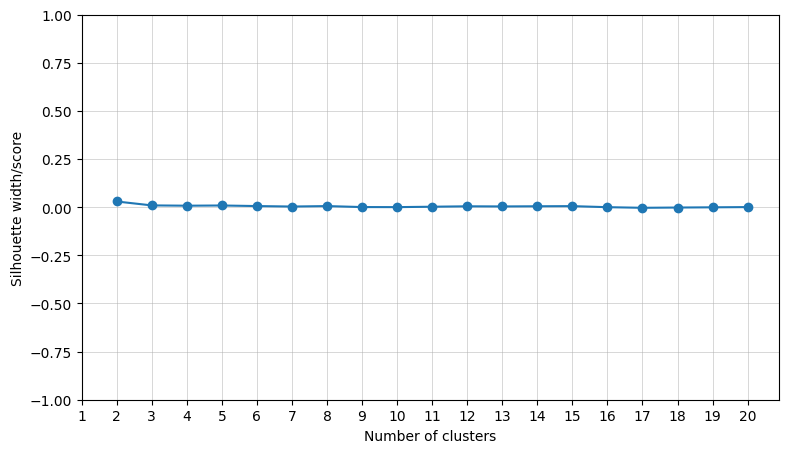

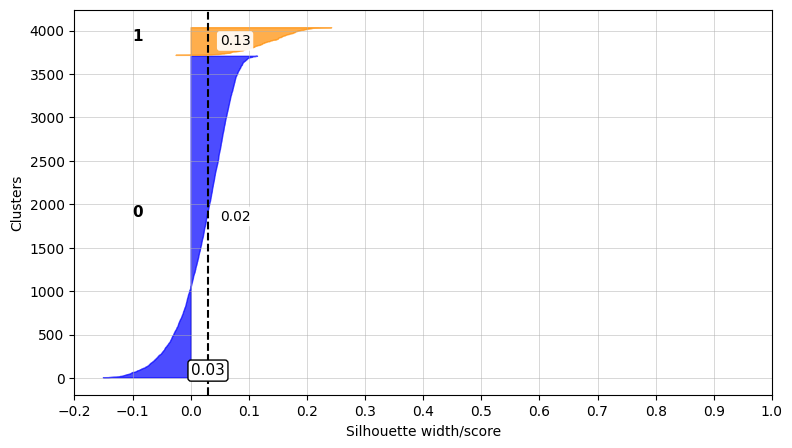

In [54]:
from Word_functions.embedding_based_clustering import embedding_clustering
import pandas as pd

embedding_clustering(input_df = clean_data,
                     output_folder = "RTMR_Output/Abstracts",
                     batch_size = 32
                    )

===========================================================================================================================

### Run R script for:
* Negative Binomial (Pruning)
* Word Frequency
* Topic Modelling
* Term Co-occurrences

##### using van Lissa's R code
  
===========================================================================================================================

In [ ]:
os.chdir("Word_functions")
r_script_path = 'abstracts_processing.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

**NOTE**

**If an error occurs in relation to "htmltools", please go directly to the `renv.lock` file, look for `"htmltools":` and try to change the package's version from 0.5.8 to 0.5.7**

## I. Word Frequency

In [ ]:
freq_df = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_freq.csv").sort_values(by= "Frequency", ascending=False).reset_index()
len(freq_df)

======================================================================================================

**Short Visualization**

In [ ]:
plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)

# Filter out the word "radicalism" and sort by frequency
plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by="Frequency", ascending=False).head(50)

highlight_words = []
colors = ['skyblue' if word not in highlight_words else 'pink' for word in plt_df['Word']]

plt.figure(figsize=(18, 4))
plt.bar(plt_df['Word'], plt_df['Frequency'], color=colors)

plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Phenomena', fontsize=12)
plt.title('Frequency of Phenomena', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Remove the black frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', linewidth=0.7, color='gray')
ax.set_axisbelow(True)

plt.savefig('RTMR_Output/Abstracts/abstracts_frequency_of_words_short.png', bbox_inches='tight', dpi=600)
plt.show()

## Frequency with Categories

In [ ]:
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience", "family"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)

plt.figure(figsize=(10, 14))

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for terms occurring in theory
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 2', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/Abstracts/abstractsfull_frequency_of_words_wide.png', bbox_inches='tight', dpi=600)

#### Narrow Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "determination"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience", "family"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)

plt.figure(figsize=(3.5, 13))  # Adjusted figure size to make it more balanced

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

# Set X-axis with steps of 50
x_min, x_max = plt.xlim()
plt.xticks(np.arange(x_min, x_max, 100))

# Adjust Y-axis limits
plt.ylim(-0.5, len(plt_df['Word']) - 0.25)

# Add lines
plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)

# Remove black frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.xlabel('Frequency Analysis 2', fontsize=12)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)

# Create legend
micro_legend = mlines.Line2D([], [], color=color_mapping['micro'], marker='o', linestyle='None', markersize=7, label='Micro')
meso_legend = mlines.Line2D([], [], color=color_mapping['meso'], marker='s', linestyle='None', markersize=7, label='Meso')
macro_legend = mlines.Line2D([], [], color=color_mapping['macro'], marker='v', linestyle='None', markersize=7, label='Macro')
radicalism_legend = mlines.Line2D([], [], color=color_mapping['radicalism'], marker='D', linestyle='None', markersize=7, label='Radicalism')

plt.legend(handles=[micro_legend, meso_legend, macro_legend, radicalism_legend], loc='lower right')

# Save figure
plt.savefig('RTMR_Output/Abstracts/abstractsfull_frequency_of_words_narrow.png', bbox_inches='tight', dpi=600)


#### Fuse frequency anlyses plots from keywords and abstracts

In [ ]:
from PIL import Image

image1 = Image.open('RTMR_Output/Keywords/keywordsfull_frequency_of_words_narrow.png')
image2 = Image.open('RTMR_Output/Abstracts/abstractsfull_frequency_of_words_narrow.png')

# Get the width and height of each image
width1, height1 = image1.size
width2, height2 = image2.size

total_width = width1 + width2
max_height = max(height1, height2)

new_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

# Paste the two images into the new image
new_image.paste(image1, (0, 0))
new_image.paste(image2, (width1, 0))

new_image.save('RTMR_Output/combined_frequency_analysis.png', dpi=(600, 600))
new_image.show()


======================================================================================================

## II. Co-occurrences

In [ ]:
cooc_df_incl = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_inclrad.csv")
cooc_df_excl = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_worad.csv")
cooc_df_ado = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_adolescence.csv")
cooc_df_islamist = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_islamist.csv")
cooc_df_right = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_far-right.csv")
cooc_df_left = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_far-left.csv")
cooc_df_lone = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_lone-actor.csv")
cooc_df_foreignf = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_foreign-fighter.csv")
cooc_df_malesup = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_cooc_male-supremacist.csv")

In [ ]:
print("Edges: ", len(cooc_df_incl))
print("Nodes: ", len(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))
print("Min number of co-occurrences: ", cooc_df_incl.cooc.min())

### Network Visualisation

#### a) General Network

In [ ]:
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "determination"
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience", "family"
]

radicalism_nodes = ["radicalism", "far right", "islamist"]

# Create the graph
G = nx.Graph()

# Add edges with corresponding frequency as weight
for index, row in cooc_df_incl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Spring layout
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors: grey if connected to radicalism, otherwise blue
edge_colors = ['grey' if 'radicalism' in (u, v) else '#5495a4' for u, v in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=15, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=15, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=15, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=15, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='lower right', fontsize=15, markerscale=1)

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()

#### Fuse General Networks from Keywords and Abstracts

In [ ]:
from PIL import Image, ImageDraw, ImageFont
# Load the images
image1 = Image.open('RTMR_Output/Keywords/keywords_cooccurrence_radicalism.png')
image2 = Image.open('RTMR_Output/Abstracts/abstracts_cooccurrence_radicalism.png')

# Get the width and height of each image
width1, height1 = image1.size
width2, height2 = image2.size

# Create a new image with the same width and the combined height of the two images
total_height = height1 + height2
total_width = max(width1, width2)

new_image = Image.new('RGB', (total_width, total_height), (255, 255, 255))

# Paste the two images into the new image
new_image.paste(image1, (0, 0))
new_image.paste(image2, (0, height1))

# Add labels (a) and (b)
draw = ImageDraw.Draw(new_image)
font_size = 200  # Increase font size significantly

try:
    # Load a font
    font = ImageFont.truetype("arial.ttf", font_size)
except IOError:
    # Fallback to a more common font if the specific font is not available
    font = ImageFont.load_default()

# Add the labels to the images at a visible position
draw.text((50, 50), "(a)", fill="black", font=font)
draw.text((50, height1 + 50), "(b)", fill="black", font=font)

# Save the new image with a DPI of 600
new_image.save('RTMR_Output/combined_cooccurrence_radicalism.png', dpi=(600, 600))
new_image.show()


#### b) Centred on "Adolescence"

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_ado.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions
if 'adolescence' in pos and 'radicalism' in pos:
    pos['adolescence'][0] += 0.2  # Adjust x position
    pos['adolescence'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_adolescence.png', bbox_inches='tight', dpi=600)
plt.show()

#### c) Centred on "Islamist"

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "islamist", "foreign fighter"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_islamist.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=1.5, iterations=100)  # positions for all nodes

# Adjust positions
if 'islamist' in pos:
    pos['islamist'][1] += 0.002  # Adjust y position slightly by 2 mm
if 'radicalism' in pos:
    pos['radicalism'][1] -= 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_islamist.png', bbox_inches='tight', dpi=600)
plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_islamist.png', bbox_inches='tight', pad_inches=-0.4, dpi=600)

plt.show()

#### d) Centred on "Far Right"

In [ ]:
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change",
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience", "family"
]

radicalism_nodes = ["radicalism", "far right"]

# Create the graph
G = nx.Graph()

# Add edges with corresponding frequency as weight
for index, row in cooc_df_right.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Spring layout
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Adjust positions
if "far right" in pos and "radicalism" in pos:
    pos["far right"][0] += 0.1  # Adjust x position
    pos["far right"][1] += 0.1  # Adjust y position

# Draw nodes with shape based on category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors
edge_colors = ['grey' for _ in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_farright.png', bbox_inches='tight', dpi=600)
plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_farright.png', bbox_inches='tight', pad_inches=-0.4, dpi=600)

plt.show()

#### without radicalism

In [ ]:
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience", "family"
]

radicalism_terms = ['far right']

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_right.iterrows():
    if row['term1'] != "radicalism" and row['term2'] != "radicalism":
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Spring layout
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

edge_colors = ['grey' for _ in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_farright_excluding_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()


#### e) Centred on "Far Left"

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "far left", "islamist", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_left.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G, seed=43, k=0.1, iterations=100)  # positions for all nodes

# Adjust positions
if 'far left' in pos:
    pos['far left'][1] += 0.002  # Adjust y position slightly by 2 mm
if 'radicalism' in pos:
    pos['radicalism'][1] -= 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# legend for fused graph
#legend_elements = [
#    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=15, label='Micro Level'),
#    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=15, label='Meso Level'),
#    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=15, label='Macro Level'),
#    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=15, label='Radicalism')
#]

#plt.legend(handles=legend_elements, loc='lower right', fontsize=15)

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_farleft.png', bbox_inches='tight', dpi=600)
plt.show()

#### Without Radicalism

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["far left", "islamist", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_left.iterrows():
    if 'radicalism' not in (row['term1'], row['term2']):
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes, more compact layout

# Adjust positions to separate 'far left' and other nodes
if 'far left' in pos:
    pos['far left'][1] += 0.002  # Adjust y position slightly by 2 mm

color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_farleft_excludingradicalism.png', bbox_inches='tight', dpi=600)
plt.show()

#### f) Centred on "Lone Actor"

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["lone actor", "radicalism"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_lone.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes

# Adjust positions
if 'lone actor' in pos:
    pos['lone actor'][1] += 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_loneactor.png', bbox_inches='tight', dpi=600)
plt.show()

#### Without Radicalism

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["lone actor"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_lone.iterrows():
    if row['term1'] != "radicalism" and row['term2'] != "radicalism":
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes

# Adjust positions
if 'lone actor' in pos:
    pos['lone actor'][1] += 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = [node for node in categories['radicalism'] if node != "radicalism"]

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_loneactor_excludingradicalism.png', bbox_inches='tight', dpi=600)
plt.show()

#### g) Centred on "Foreign Fighter"

In [ ]:
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration", "country muslim"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience", "family"
    ],
    'radicalism': ["radicalism", "foreign fighter", "islamist"]
}

# Create the graph
G = nx.Graph()

# Add edges with corresponding frequency as weight
for index, row in cooc_df_foreignf.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(16, 12))

# Spring layout
pos = nx.spring_layout(G, seed=43, k=8, iterations=200)

# Function to adjust overlapping nodes
def adjust_node_positions(pos, min_distance=0.1):
    adjusted_pos = pos.copy()
    for i, (node1, (x1, y1)) in enumerate(pos.items()):
        for j, (node2, (x2, y2)) in enumerate(pos.items()):
            if i >= j:
                continue
            distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
            if distance < min_distance:
                angle = np.arctan2(y2 - y1, x2 - x1)
                shift_x = min_distance * np.cos(angle)
                shift_y = min_distance * np.sin(angle)
                adjusted_pos[node2] = (x2 + shift_x, y2 + shift_y)
    return adjusted_pos

# Adjust positions to separate nodes
pos = adjust_node_positions(pos)

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10,)

# Remove frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_foreignfighter.png', bbox_inches='tight', dpi=600)

#### h) Centred on "Male Supremacist"

In [ ]:
categories = {
    'micro': ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
              "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
              "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
              "aggression", "morality", "mental health", "conservatism", "minority", "sacred values", 
              "age", "hate", "rationality", "prejudice", "uncertainty", "trust", "personality", 
              "liberalism", "intolerance", "fundamentalism", "fear", "honor", "poverty", 
              "white race", "superiority", "islamophobia", "significance quest", "social movements", 
              "masculinity", "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
              "ptsd", "resilience", "voting behavior", "misogyny"],
    'meso': ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
             "mobilization", "discourse", "integration", "family", "competition", "language", 
             "polarization", "discrimination", "group process", "recruitment", "elites", 
             "social media", "social cohesion", "social change", "sexual relationship"],
    'macro': ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
              "security", "region", "elections", "policy", "democracy", "international", 
              "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
              "immigration"],
    'theory': ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
               "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
               "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
               "policy", "nationalism", "social exclusion", "status", "dogmatism", 
               "mobilization", "authoritarianism", "integration", "aggression", "morality", 
               "competition", "crisis", "sacred values", "discrimination", "group process", 
               "rationality", "prejudice", "uncertainty", "intolerance", "military", 
               "fundamentalism", "honor", "poverty", "significance quest", "social movements", 
               "globalization", "martyrdom", "political engagement", "resilience", "family"],
    'radicalism': ["radicalism", "male supremacist"]
}

# Create the graph
G = nx.Graph()

# Add edges with corresponding frequency as weight
for index, row in cooc_df_malesup.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Spring layout
pos = nx.spring_layout(G, seed=43, k=10, iterations=200)

# Adjust positions to separate 'radicalism' and 'lone actor'
if 'lone actor' in pos and 'radicalism' in pos:
    pos['lone actor'][0] += 0.1  # Adjust x position
    pos['lone actor'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges with width and color proportional to frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/Abstracts/abstracts_cooccurrence_malesupremacist.png', bbox_inches='tight', dpi=600)

#### Fuse Islamist, Far Right, Far Left Cooc Maps

In [ ]:
# Load images
#image1 = Image.open('RTMR_Output/Abstracts/abstracts_cooccurrence_islamist.png')
#image2 = Image.open('RTMR_Output/Abstracts/abstracts_cooccurrence_farright.png')
#image3 = Image.open('RTMR_Output/Abstracts/abstracts_cooccurrence_farleft.png')

# Get width and height of each image
#width1, height1 = image1.size
#width2, height2 = image2.size
#width3, height3 = image3.size

# Calculate total height and maximum width
#total_height = height1 + height2 + height3
#total_width = max(width1, width2, width3)

# Create new image with the same width and the combined height of the three images
#new_image = Image.new('RGB', (total_width, total_height), (255, 255, 255))

# Calculate the x positions to center the images
#x_offset1 = (total_width - width1) // 2
#x_offset2 = (total_width - width2) // 2
#x_offset3 = (total_width - width3) // 2

# Paste the three images into the new image at the calculated x positions
#new_image.paste(image1, (x_offset1, 0))
#new_image.paste(image2, (x_offset2, height1))
#new_image.paste(image3, (x_offset3, height1 + height2))

# Add labels (a), (b), and (c)
#draw = ImageDraw.Draw(new_image)
#font_size = 200  # Adjust font size as needed

#try:
#    # Load a font
#    font = ImageFont.truetype("arial.ttf", font_size)
#except IOError:
#    # Fallback to a more common font if the specific font is not available
#    font = ImageFont.load_default()

# Set a fixed x position for the labels near the left edge
#label_x_position = 50

# Add the labels to the images at a visible position
#draw.text((label_x_position, 50), "(a)", fill="black", font=font)
#draw.text((label_x_position, height1 + 50), "(b)", fill="black", font=font)
#draw.text((label_x_position, height1 + height2 + 50), "(c)", fill="black", font=font)

#new_image.save('RTMR_Output/combined_cooccurrence_islamist_farright_farleft.png', dpi=(600, 600))
#new_image.show()


### III. Comparison of Study 1 (Keywords) and Study 2 (Abstract)

**Overlapping terms for frequencies**

In [ ]:
freq_df_st1 = pd.read_csv(r"RTMR_Output/Keywords/Keywords_freq.csv").sort_values(by= "Frequency", ascending=False).reset_index()
freq_df_st2 = pd.read_csv(r"RTMR_Output/Abstracts/Abstracts_freq.csv").sort_values(by= "Frequency", ascending=False).reset_index()

In [ ]:
print("Percentage of overlapping terms, based on study 1 (Keywords): ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ) / len(freq_df_st1.Word) )
print("Percentage of overlapping terms, based on study 2 (Abstracts): ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ) / len(freq_df_st2.Word) )
print("Absolute number of overlapping terms: ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ))

In [ ]:
## Unique terms per analysis

print("Unique terms in KW analysis: \n", set(freq_df_st1.Word).difference(set(freq_df_st2.Word)))
print("\nUnique terms in Abstract analysis: \n", set(freq_df_st2.Word).difference(set(freq_df_st1.Word)))

## Mental Health

### Mental Health Occurrence Across Time for Abstracts

In [ ]:
year_df = dfTot[["record_id","Publication Year"]]

In [ ]:
study2 = clean_data.drop(columns = ["cat_keywords"])

In [ ]:
merged_df = pd.merge(year_df, study2, on='record_id', how='outer')
merged_df

In [ ]:
# Replace NaN values with empty lists
merged_df['cat_keywords2'] = merged_df['cat_keywords2'].apply(lambda x: x if isinstance(x, list) else [])


In [ ]:
articles_per_year = Counter(merged_df["Publication Year"])

In [ ]:
check_term = "mental health"

In [ ]:
rels = merged_df[merged_df['cat_keywords2'].apply(lambda x: check_term in x)]
mental_health_per_year = Counter(rels["Publication Year"])

In [ ]:
corrected_years = dict()
for key, value in mental_health_per_year.items():
    corrected_years[key] = value / articles_per_year[key]

corrected_years = dict(sorted(corrected_years.items()))

In [ ]:
# Determine range of years
min_year = min(corrected_years.keys())
max_year = max(corrected_years.keys())

# Create list of all years in the range
all_years = list(range(min_year, max_year + 1))

# Get frequencies for all years, using 0 for years with no data
frequencies = [corrected_years.get(year, 0) for year in all_years]

# Plot histogram
plt.figure(figsize=(10, 6))

plt.bar(all_years, frequencies, edgecolor='black', color='gray')

# Customize x-axis
plt.xticks(all_years, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year', fontsize=12, labelpad=15)  # Add padding
plt.ylabel(f'Frequency of {check_term}', fontsize=12, labelpad=15)  # Add padding


plt.grid(False)

plt.savefig('RTMR_Output/Abstracts/Abstracts_mental-health_hist.png', bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

### Mental Health occurrence across time for Keywords & Abstracts

In [ ]:
year_df = dfTot[["record_id","Publication Year"]]

In [ ]:
study1 = pd.read_json("RTMR_Output/Keywords/Keywords_clean_data.json")
study2 = clean_data.drop(columns = ["cat_keywords"])

In [ ]:
merged_df = pd.merge(study1, study2, on='record_id', how='outer')
merged_df = pd.merge(year_df, merged_df, on='record_id', how='outer')
merged_df

In [ ]:
# Replace NaN values with empty lists
merged_df['cat_keywords'] = merged_df['cat_keywords'].apply(lambda x: x if isinstance(x, list) else [])
merged_df['cat_keywords2'] = merged_df['cat_keywords2'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
articles_per_year = Counter(merged_df["Publication Year"])

In [ ]:
check_term = "mental health"

In [ ]:
rels = merged_df[merged_df['cat_keywords'].apply(lambda x: check_term in x) | merged_df['cat_keywords2'].apply(lambda x: check_term in x)]
mental_health_per_year = Counter(rels["Publication Year"])

In [ ]:
corrected_years = dict()
for key, value in mental_health_per_year.items():
    corrected_years[key] = value / articles_per_year[key]

corrected_years = dict(sorted(corrected_years.items()))

In [ ]:
# Determine the range of years
min_year = min(corrected_years.keys())
max_year = max(corrected_years.keys())

# Create a list of all years in the range
all_years = list(range(min_year, max_year + 1))

# Get the frequencies for all years, using 0 for years with no data
frequencies = [corrected_years.get(year, 0) for year in all_years]

# Plot histogram
plt.figure(figsize=(10, 6))

plt.bar(all_years, frequencies, edgecolor='black', color='gray')

# Customize x-axis labels for better detail
plt.xticks(all_years, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year', fontsize=12, labelpad=15)  # Add padding
plt.ylabel(f'Frequency of "{check_term}"', fontsize=12, labelpad=15)  # Add padding

plt.grid(False)

plt.savefig('RTMR_Output/mental-health_hist_Abstracts&Keywords.png', bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

## Terms Not Occurring in Co-occurrence

In [ ]:
print("Terms not occurring in co-occurrnece maps: \n", set(list(freq_df.Word)).difference(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))

## Binomial Test for Within vs. Between Category Co-occurrences

In [ ]:
data_chi = cooc_df_excl.copy(deep=True)
data_chi

In [ ]:
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "immigration", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority", 
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "discourse", 
    "family", "competition", "polarization", "discrimination", "group process", 
    "recruitment", "elites", "social media", "social coherence", "mobilization", 
    "integration"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", "norms", 
    "culture", "internet", "security", "region", "elections", "policy", "democracy", 
    "language", "international", "crisis", "institutions", "peace", "propaganda", 
    "military"
]

def categorize_terms(term):
    if term in micro_terms:
        return 'micro'
    elif term in meso_terms:
        return 'meso'
    elif term in macro_terms:
        return 'macro'
    else:
        return 'unknown'

In [ ]:
# Apply categorization to terms
data_chi['category1'] = data_chi['term1'].apply(categorize_terms)
data_chi['category2'] = data_chi['term2'].apply(categorize_terms)

# Filter out unknown categories
cooc_df_filtered = data_chi[(data_chi['category1'] != 'unknown') & (data_chi['category2'] != 'unknown')]
cooc_df_filtered

In [ ]:
## how often do the levels occurr
freq_levels = Counter(list(cooc_df_filtered.category1) + list(cooc_df_filtered.category2))
total_nodes = np.sum(list(freq_levels.values()))
for key, value in freq_levels.items():
    freq_levels[key] = value / total_nodes
freq_levels

In [ ]:
corrected_cooc = []
total_edges = cooc_df_filtered.cooc.sum()
for idx in cooc_df_filtered.index:
    corrected_cooc.append( (cooc_df_filtered.loc[idx, "cooc"] / total_edges) / (freq_levels[cooc_df_filtered.loc[idx, "category1"]] * freq_levels[cooc_df_filtered.loc[idx, "category2"]]))

cooc_df_filtered["corrected_cooc"] = corrected_cooc
cooc_df_filtered

In [ ]:
n = cooc_df_filtered.cooc.sum()
n

In [ ]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

In [ ]:
from scipy.stats import binom_test
print(binom_test(x=occ_between, n= n, p=1/2))
print(binom_test(x=occ_within, n= n, p=1/2))